In [1]:
# 自作モジュールの参照先を上書き
import sys
parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride


import time
import pickle

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch.optim import Adam

from module.lino_module.preprocess import mode_of_freq, tde_dataset_wm, select_device
from module.lino_module.model import TransformerModel
from module.lino_module.training import training
from module.lino_module.ploter import learning_plot, confirmation, to_time_series,\
                                        confirmation_plot

# 乱数固定
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

/Users/lino/opt/anaconda3/envs/for_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データセットの準備

In [2]:
data = pd.read_csv('../data/sales_train.csv')
data = mode_of_freq(data).item_cnt_day
seq = 7
d_model = 24
dilation = 2
src_tgt_seq = (int(seq * 0.7),int(seq * 0.7))
step_num = seq - int(seq * 0.7)
scaler = StandardScaler

kwrgs = {'data': data,
         'seq': seq,
         'd_model': d_model,
         'dilation': dilation,
         'src_tgt_seq': src_tgt_seq,
         'step_num': step_num,
         'daily': False,
         'weekly': True,
         'weekly_num': False,
         'monthly': True,
         'scaler': scaler,
         'batch_size': 64,
         'train_rate': 0.9}

train, test = tde_dataset_wm(**kwrgs)

## Transformerモデルの準備

In [3]:
# device = select_device() # mps では Transformer の attention でエラー
device = torch.device('cpu')

cat_dim = kwrgs['daily'] + kwrgs['weekly'] + kwrgs['weekly_num'] + kwrgs['monthly']
dim = d_model * (cat_dim + 1)

# モデルと損失関数
transformer = TransformerModel(d_model=dim, nhead=8, device=device).to(device)
# criterion = RMSELoss()  # 論文ではRMSELoss
criterion = nn.MSELoss().to(device)

# 学習率その他は論文の値を参考
warmup_steps = 5000
lr = d_model**0.5 * min(step_num**0.5, step_num * warmup_steps**(-1.5))
optimizer = Adam(transformer.parameters(), lr=1e-5, betas=(0.95, 0.98), eps=10e-9)

## 訓練

In [4]:
epochs = 100
training_kwrgs = {'model': transformer,
                  'train': train,
                  'test': test,
                  'device': device,
                  'criterion': criterion,
                  'optimizer': optimizer,
                  'epochs': epochs,
                  'verbose': 10,
                  'center': 50}
transformer, loss_pack = training(**training_kwrgs)
train_loss, validation_loss, test_loss = loss_pack

--------------------- start ----------------------
                     epoch_0                      
train_loss:  1.1618 | validation_loss:  1.1692 | test_loss:  1.7282
                     epoch_10                     
train_loss:  0.6313 | validation_loss:  0.5491 | test_loss:  0.4118
                     epoch_20                     
train_loss:  0.5063 | validation_loss:  0.4088 | test_loss:  0.1744
                     epoch_30                     
train_loss:  0.4246 | validation_loss:  0.3357 | test_loss:  0.152
                     epoch_40                     
train_loss:  0.3867 | validation_loss:  0.2883 | test_loss:  0.14
                     epoch_50                     
train_loss:  0.3393 | validation_loss:  0.2582 | test_loss:  0.1432
                     epoch_60                     
train_loss:  0.319 | validation_loss:  0.2341 | test_loss:  0.137
                     epoch_70                     
train_loss:  0.298 | validation_loss:  0.2184 | test_loss:  0.1346
   

## 訓練データ損失と検証データ損失

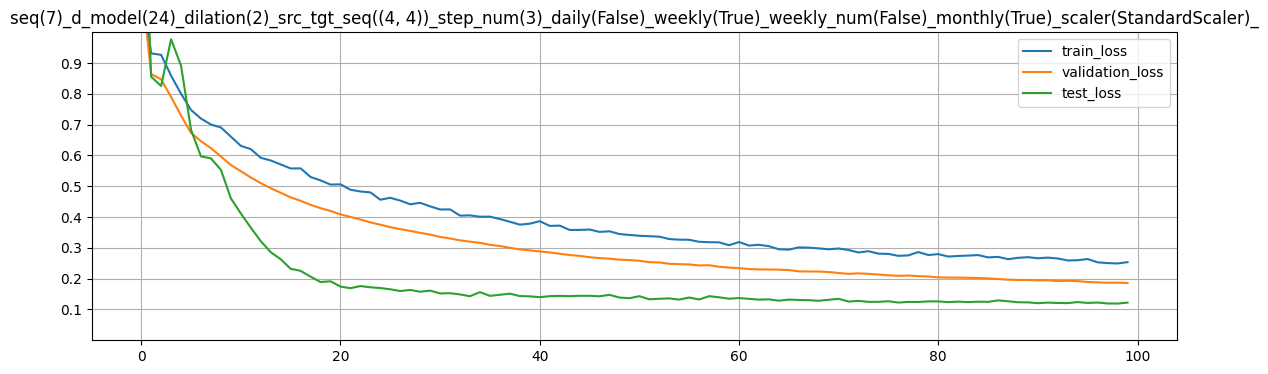

In [5]:
# ファイル名の作成
name = ''
for key, value in kwrgs.items():
    if key=='data':
        pass
    elif key=='scaler':
        name += f'{key}({value.__name__})_'
    else:
        name += f'{key}({value})_'

img_path = './img_wm/'
figsize = (14, 4)
saving = True
learning_plot(train_loss, validation_loss, test_loss,  img_path, name, scaler, figsize, saving)

## 訓練データとテストデータで予測

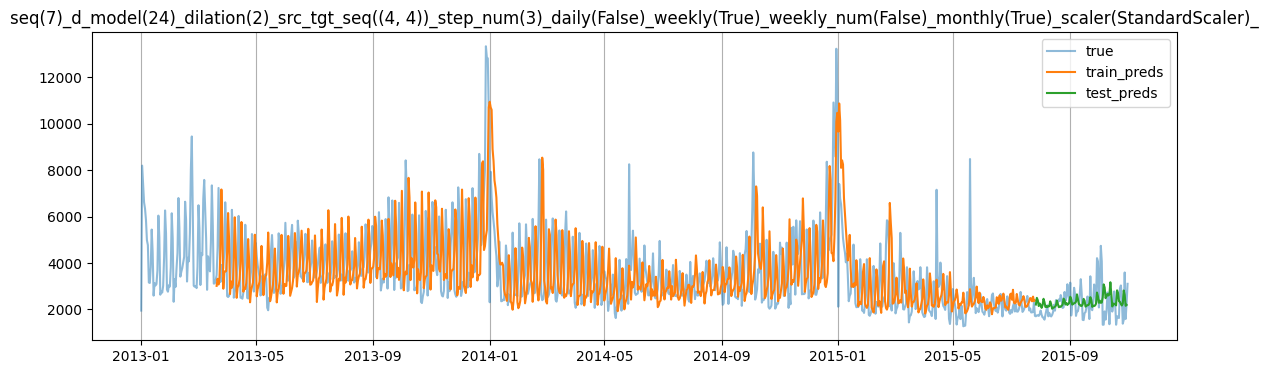

In [6]:
figsize = (14, 4)
train_preds, test_preds = confirmation(transformer, train, test, device)
train_time_series, test_time_series, original = to_time_series(data, train_preds, test_preds, scaler, d_model, dilation, seq)
confirmation_plot(train_time_series, test_time_series, original, img_path, name, figsize, saving)

In [8]:
len(train_preds), len(test_preds)

(14, 96)

In [9]:
train_preds[0].shape, test_preds[0].shape

(torch.Size([64, 1]), torch.Size([1, 1]))

### 以下は訓練のために作成したクラスおよび関数

In [7]:
import datetime

import pandas as pd
import numpy as np
import torch

from module.lino_module.preprocess import src_tgt_split

from typing import Tuple, Optional, Union
from numpy import ndarray
from pandas import DataFrame, Series, Timestamp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import Tensor


class RecurrentInference():
    """再起的に推論を行うクラス"""
    def __init__(self, model, seq, d_model, dilation, src_tgt_seq, step_num,
                 daily, weekly, weekly_num, monthly):
        """ Initializer
        引数:
            model: 訓練済みモデル
            seq: 訓練条件時の seq
            d_model: 訓練条件時の d_model
            dilation: 訓練条件時の dilation
            src_tgt_seq: 訓練条件時の src_tgt_seq,
            step_num: 一回の推論における予測日数
            daily: 訓練条件時の日付情報の有無
            weekly: 訓練条件時の曜日情報の有無
            weekly_num: 訓練条件時の週次情報の有無
            monthly: 訓練条件時の月次情報の有無
        """
        self.model: object = model
        self.seq: int = seq
        self.d_model: int = d_model
        self.dilation: int = dilation
        self.src_tgt_seq: Tuple[int] = src_tgt_seq
        self.step_num: int = step_num
        self.daily: bool = daily
        self.weekly: bool = weekly
        self.weekly_num: bool = weekly_num
        self.monthly: bool = monthly

        self.origin: Optional[Series] = None
        self.df: Optional[DataFrame] = None
        self.inferenced: Optional[Series] = None
        self.embedded: Optional[ndarray] = None
        self.latest_index: Optional[Timestamp] = None
        self.latest_data: Optional[float] = None
        self.scaler: Optional[object] = None

    def __call__(self, ds: Series, scaler: Union[StandardScaler, MinMaxScaler]):
        """入力データを登録
        引数:
            ds: 訓練データセット作成時に使用したシリーズ
            scaler: 訓練時に使用したスケーラー
        """
        self.origin = ds.copy()
        reshaped = ds.values.reshape(-1, 1)
        self.scaler = scaler().fit(reshaped)
        scaled_ds = self.scaler.transform(reshaped).reshape(-1)

        # 入力データから推論に持ちるデータフレームを生成
        self.df = pd.DataFrame(scaled_ds,
                               columns=['data'],
                               index=ds.index.tolist())
        # 推論結果を書くのするデータフレームを生成
        self.latest_index = ds.index[-self.step_num:]
        self.latest_data = ds[-self.step_num:]
        self.inferenced = pd.Series(self.latest_data, index=self.latest_index)

        if self.daily:
            self.df['daily'] = ds.index.day / 31
        if self.weekly:
            self.df['weekly'] = ds.index.weekday / 6
        if self.weekly_num:
            scaled_calendar = (ds.index.isocalendar().week - 1) / 44
            self.df['weekly_num'] = scaled_calendar.values
        if self.monthly:
            self.df['monthly'] = (ds.index.month - 1) / 11

    def predict(self, freq):
        """推論用関数
        引数:
            freq: 再帰推論回数
        """
        for _ in range(freq):
            self.embedded = self.tde(self.df,
                                     self.seq,
                                     self.d_model,
                                     self.dilation)
            src, tgt = src_tgt_split(self.embedded, *self.src_tgt_seq)
            output = self.inference(self.model, src, tgt).reshape(-1)
            scaled = output[-self.step_num:]
            inversed = self.scaler.inverse_transform(scaled.reshape(-1, 1))
            inversed = inversed.reshape(-1)

            # 推論の追加
            self.latest_index += datetime.timedelta(self.step_num)
            inferenced = pd.Series(inversed, index=self.latest_index)
            self.inferenced = pd.concat((self.inferenced, inferenced))

            # datasetの更新
            latest_data = {'data': scaled}
            if self.daily:
                scaled_daily = self.latest_index.day / 31
                latest_data['daily'] = scaled_daily
            if self.weekly:
                scaled_weekday = self.latest_index.weekday / 6
                latest_data['weekly'] = scaled_weekday
            if self.weekly_num:
                scaled_weekly_num = (self.latest_index.isocalendar().week - 1) / 44
                latest_data['weekly_num'] = scaled_weekly_num
            if self.monthly:
                scaled_month = (self.latest_index.month - 1) / 11
                latest_data['monthly'] = scaled_month
            latest = pd.DataFrame(latest_data, index=self.latest_index)
            self.df = pd.concat((self.df, latest))
        return self.inferenced

    @classmethod
    def tde(self,
            df: DataFrame,
            seq: int,
            d_model: int,
            dilation: int
            ) -> ndarray:
        """Time delay Embedding
           入力データ末端のseq分からTDEデータを作成
        引数:
            df: [data, weekly, monthly]のカラムと Timestamp インデックスを持ったデータフレーム
            seq: 訓練条件時の seq
            d_model: 訓練条件時の d_model
            dilation: 訓練条件時の dilation
        """
        embeded = []
        for column in df.columns:
            trg = getattr(df, column)
            tded = self.tde_for_inference(trg, seq, d_model, dilation)
            embeded.append(tded.tolist())
        embeded = np.array(embeded).reshape(d_model*len(df.columns), -1)
        return embeded

    @classmethod
    def inference(self, model: object, src: Tensor, tgt: Tensor) -> ndarray:
        """推論関数
        """
        src = torch.from_numpy(src.astype(np.float32)).unsqueeze(0)
        tgt = torch.from_numpy(tgt.astype(np.float32)).unsqueeze(0)
        model.eval()
        output = model(src, tgt).detach().numpy()
        return output

    @classmethod
    def tde_for_inference(self,
                          ds: Series,
                          seq: int,
                          d_model: int,
                          dilation: int
                          ) -> ndarray:
        for_array = []
        for i in range(d_model):
            if i != 0:
                for_array.append(ds[-seq - i*(dilation + 1): -i*(dilation + 1)])
            else:
                for_array.append(ds[-seq:])
        time_delay_embedded = np.array([j for j in reversed(for_array)])
        return time_delay_embedded